# Прогнозирование оттока и кластеризация клиентов сети фитнес-центров

## Описание проекта и импорт данных

### Заказчик и цель исследования

Заказчик: сеть фитнес центров "Культурист-датасаентист"

Заказчик хочет бороться с оттоком клиентов. Отпавшим считается клиент, который за последний месяц ни разу не сходил в зал. Заказчик предоставил данные анкет пользователей по которым нужно провести анализ, а именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    * выделить целевые группы клиентов;
    * предложить меры по снижению оттока;
    * определить другие особенности взаимодействия с клиентами.

### Описание данных

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.

### Импорт библиотек и данных

In [3]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import plotly.figure_factory as ff
import plotly.io as pio
import warnings

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

warnings.filterwarnings('ignore')
pio.renderers.default='jpeg'

In [4]:
# функция для настройки стиля в графиках
def style_plot(
    xlabel='',
    ylabel='',
    title='',
    yticks=True  
):
    
    fig.update_layout(
        autosize=True,
        xaxis_title_text=xlabel,
        yaxis_title_text=ylabel,
        plot_bgcolor='white',
        xaxis=dict(
            showline=True,
            linecolor='#58595B',
            color='black',
            categoryorder='total descending'
        ),
        yaxis=dict(
            color='black',
            showgrid=True,
            gridcolor='#E6E7E8',
            showticklabels=yticks
        ),
        title=dict(
            text=title,
            font=dict(
                color='black'
            )
        )
    )

# цвета для графиков
colors = ['#' +i for i in ["264653","2a9d8f","e9c46a","f4a261","e76f51"]]

In [5]:
# настроим некоторые параметры отображения графиков
custom_params = {
    'figure.figsize': (14,6),
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'grid.alpha': 0.5,
    'axes.formatter.limits': [-10, 10], # условия для отображения научного формата
}

for key, val in custom_params.items():
    mpl.rcParams[key] = val

In [6]:
# импортируем данные
# для локальной работы
try:
    data = pd.read_csv('datasets/gym_churn.csv')
# для jupyterhub
except:
    data = pd.read_csv('/datasets/gym_churn.csv')

## Исследовательский анализ данных

На этом шаге посмотрим какие у нас данные: размер данных, общая информация по датасету, количество пропусков, распределение признаков, корреляции признаков, описательные статистики.

Посмотрим на общую информацию по датасету:

In [7]:
# общая информация по датасету 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

У нас 14 столбцов, в которых по 4000 значений в каждом. Все столбцы имеют числовой формат. На первый взгляд пропусков в данных нет. Также сразу видны проблемы с регистром в названиях столбцов. Сразу же исправим их:

In [8]:
# переведем названия столбцов в нижний регистр
data.columns = [col.lower() for col in data.columns]

# посмотрим на результат
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Теперь выведем первые 5 строк датафрейма:

In [9]:
# вывод первых 5 строк
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Посмотрим на описательные статистики:

In [10]:
# выводим описательные статистики
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


Какие выводы из средних значений мы можем сделать:
* У нас почти поровну женщин и мужчин,
* 85% клиентов работают или живут около фитнес-центров,
* Половина клиентов являются сотрудниками компаний-партнеров,
* 31% клиентов пришли по промокоду от друзей,
* У среднего клиента текущий абонемент рассчитан на месяц,
* 41% клиентов ходят на групповые занятия,
* Средний возраст клиента 29 лет,
* Средняя выручка от дополнительных услуг фитнес-центров составляет около 150 рублей.
* 3 месяца – лайфтайм среднего клиента,
* В среднем клиент ходит в зал почти 2 раза в неделю,
* 27% клиентов в датасете ушло.

### Исследование распределений признаков

Посмотрим как распределены небинарные признаки. Построим по каждому из них гистограмму и исследуем их. Дополнительно на гистограммах разделим пользователей по признаку `churn`, чтобы иметь представление об ушедших и оставшихся пользователей.

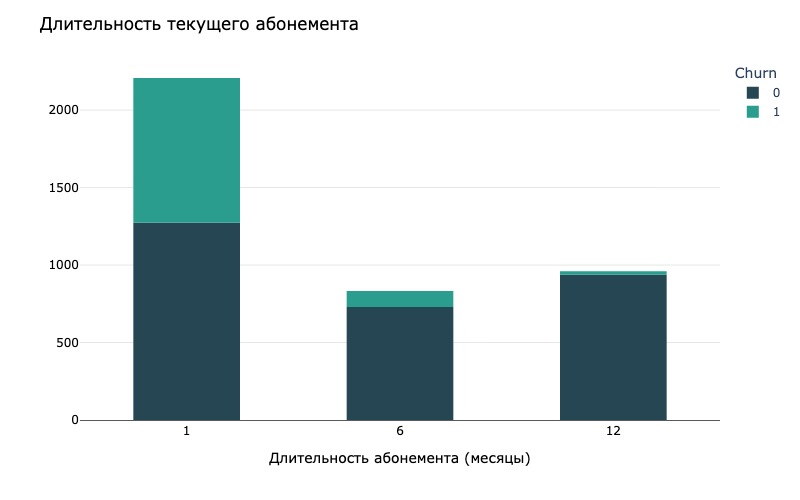

In [11]:
# длительность текущего абонемента
fig = px.histogram(
    data['contract_period'],
    width=800,
    color_discrete_sequence=colors,
    color=data['churn']
)

style_plot(
    title='Длительность текущего абонемента',
    xlabel='Длительность абонемента (месяцы)'
)

fig.update_xaxes(
    nticks=4,
    tickvals=[2,7,12],
    ticktext=[1,6,12]
)

fig.update_layout(
    bargap=0.5,
    legend_title_text='Churn'
)

fig.show()

У большинства клиентов на данный момент абонементы на 1 месяц. Также держателей годовых абонементов больше чем держателей полугодовых абонементов. У большей доли ушедших пользователей абонементы длительностью 1 месяц.

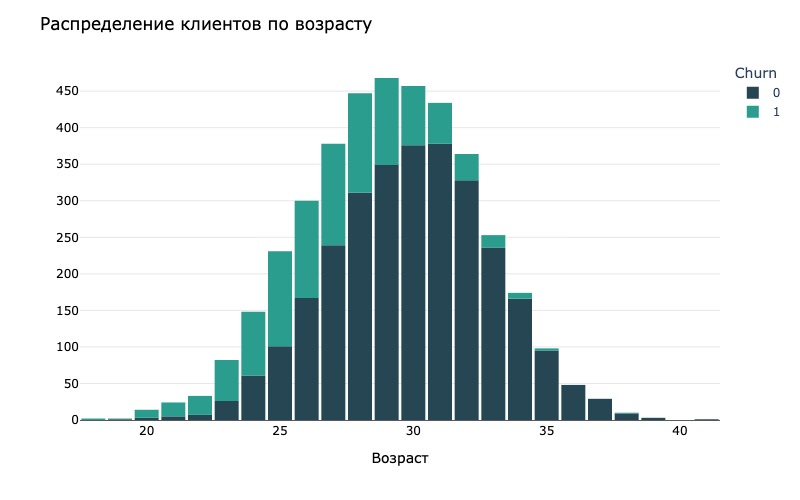

In [12]:
# распределение клиентов по возрасту
fig = px.histogram(
    data['age'],
    color_discrete_sequence=colors,
    width=800,
    labels={
        'variable': 'Признак',
        'value': 'Возраст',
        'count': 'Количество'
    },
    color=data['churn']
)

style_plot(
    title='Распределение клиентов по возрасту',
    xlabel='Возраст'
)

fig.update_layout(
    bargap=0.1,
    legend_title_text='Churn'
)

fig.show()

Распределение клиентов по возрасту очень похоже на нормальное. Пик распределения в точке 29 лет. Ситуация нормальная, и не содержит аномалий или выбросов.

Доля ушедших пользователей больше среди более молодых клиентов.

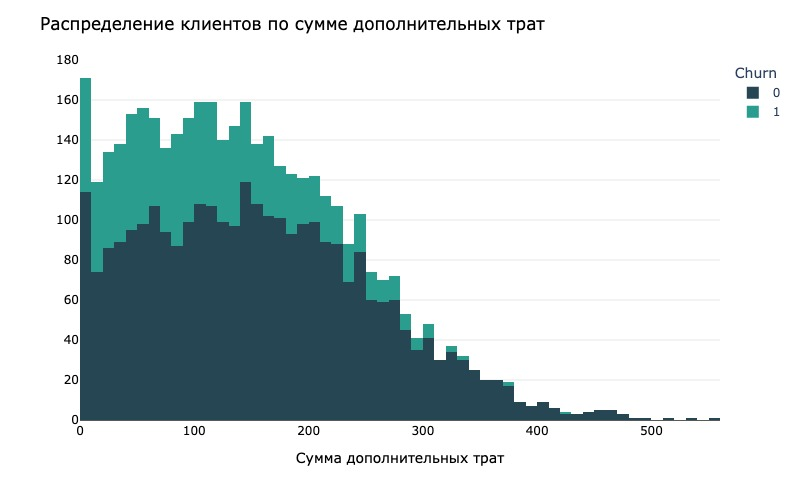

In [13]:
# распределение клиентов по сумме дополнительных трат
fig = px.histogram(
    data['avg_additional_charges_total'],
    color_discrete_sequence=colors,
    width=800,
    labels={
        'variable': 'Признак',
        'value': 'Сумма трат',
        'count': 'Количество'
    },
    color=data['churn']
)

style_plot(
    title='Распределение клиентов по сумме дополнительных трат',
    xlabel='Сумма дополнительных трат'
)

fig.update_layout(
    legend_title_text='Churn'
)

fig.show()

Большинство клиентов совершает дополнительных трат на сумму до 170 рублей. Дальше в распределении идет плавный спад. Всего 3 клиента тратят больше 500 рублей, но и эти значения назвать выбросами сложно.

Ушедшие и оставшиеся пользователи распределны примерно одинаково.

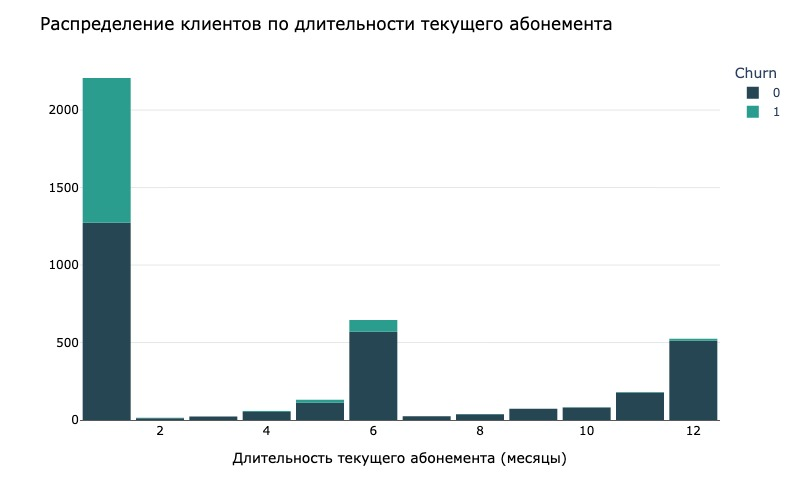

In [14]:
# распределение клиентов по длительности текущего абонемента
fig = px.histogram(
    data['month_to_end_contract'],
    width=800,
    color_discrete_sequence=colors,
    color=data['churn']
)

style_plot(
    title='Распределение клиентов по длительности текущего абонемента',
    xlabel='Длительность текущего абонемента (месяцы)'
)

fig.update_layout(
    bargap=0.1,
    legend_title_text='Churn'
)

fig.show()

Самые большие столбцы на гистограмме в точках – 1, 6 и 12 месяцев. Скорее всего большинство клиентов из этих столбцов новые покупатели абонементов, так как судя по `contract_period` фитнес центр продает абонементы именно такой длительности.

Большинство пользователей ушло, когда у них по абонементу оставался месяц занятий.

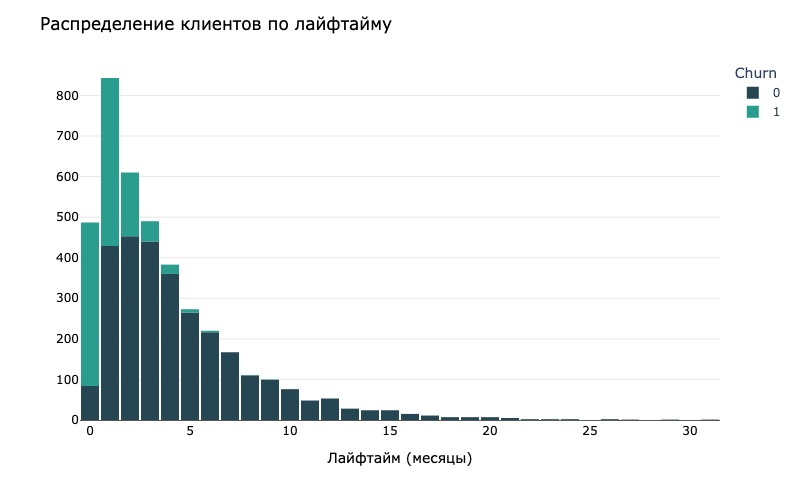

In [15]:
# распределение клиентов по лайфтайму
fig = px.histogram(
    data['lifetime'],
    width=800,
    color_discrete_sequence=colors,
    color=data['churn']
)

fig.update_layout(
    bargap=0.1,
    legend_title_text='Churn'
)

style_plot(
    title='Распределение клиентов по лайфтайму',
    xlabel='Лайфтайм (месяцы)'
)

fig.show()

Распределение лайфтайма скошено вправо. То есть большинство клиентов имеют показатель лайфтайма до 5 месяцев, а дальше виден длинный хвост вплоть до 31 месяца. Количество клиентов с лайфтаймом более 20 месяцев крайне мало, и можно считать их выбросами. Возьмем на заметку.

Чаще уходят пользователи, у которых лайфтайм менее 3-х месяцев.

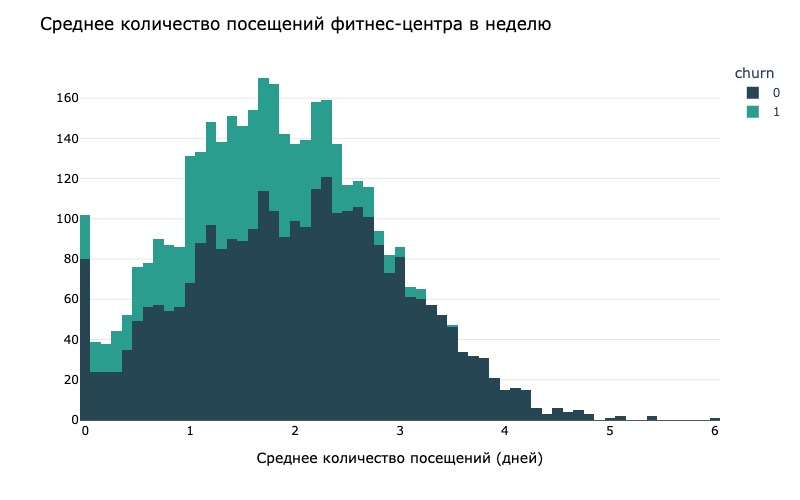

In [16]:
fig = px.histogram(
    data['avg_class_frequency_total'],
    color = data['churn'],
    width=800,
    color_discrete_sequence=colors
)

style_plot(
    title='Среднее количество посещений фитнес-центра в неделю',
    xlabel='Среднее количество посещений (дней)'
)

fig.update_layout(
    legend_title_text='churn'
)

fig.show()

Большинство клиентов ходят в фитнес-центр от 1 до 3-х раз в неделю. Поведение ушедших клиентов в этом плане не сильно отличается от оставшихся.

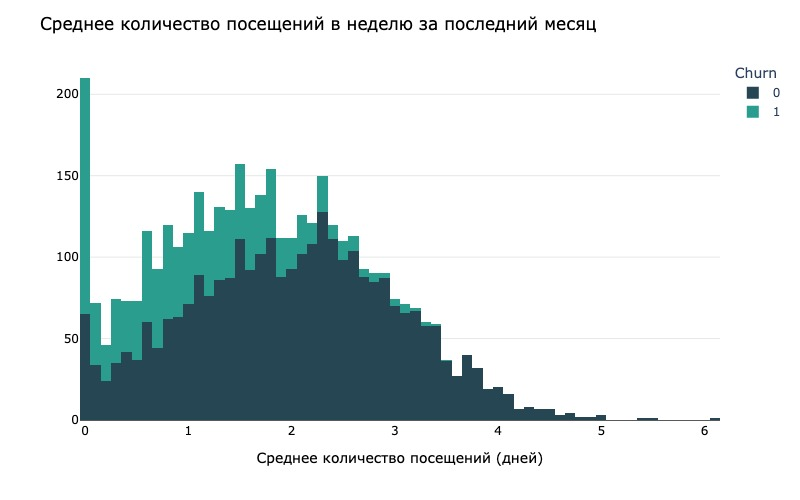

In [17]:
# среднее количество посещений за последний месяц
fig = px.histogram(
    data['avg_class_frequency_current_month'],
    width=800,
    color=data['churn'],
    color_discrete_sequence=colors
)

style_plot(
    title='Среднее количество посещений в неделю за последний месяц',
    xlabel='Среднее количество посещений (дней)'
)

fig.update_layout(
    legend_title_text='Churn'
)

fig.show()

В целом ситуация в среднем количестве посещений за последний месяц не сильно отличается от предыдущего графика. За исключением того, что очень большая доля ушедших клиентов в последний месяц вовсе не ходила в зал.

Теперь посмотрим как признаки коррелируют между собой. Для этого построим матрицу корреляций и тепловую карту.

<AxesSubplot:>

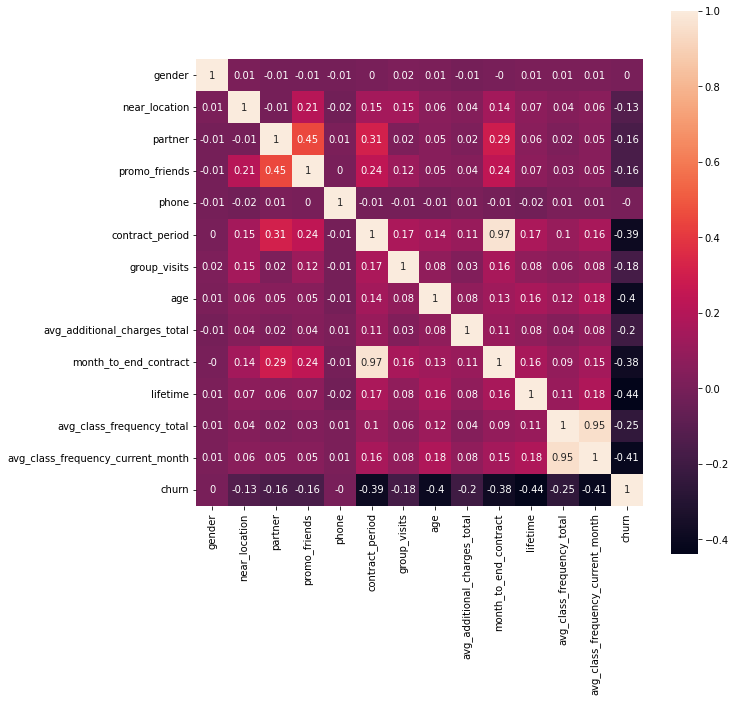

In [18]:
plt.figure(figsize=(10,10))

# строим тепловую карту 
sns.heatmap(
    data.corr().round(2),
    annot=True,
    square=True
    )

Сильные корреляции (свыше 0.9 по модулю):
* Длительность текущего абонемента – Срок до окончания абонемента,
* Среднее количество посещений в неделю за весь лайфтайм – Среднее количество посещений в неделю за последний месяц

Средние корреляции (от 0.4 до 0.9 по модулю):
* Сотрудник компании-партнера – Первоначальная запись в рамках акции "приведи друга",
* Возраст – Факт оттока,
* Лайфтайм – Факт оттока,
* Среднее количество посещений в неделю за последний месяц – Факт оттока

По остальным признакам, корреляция совсем небольшая.

### Выводы

Мы провели исследовательский анализ данных в три этапа: анализ средних значений, анализ распредлений, анализ корреляций.

Основные выводы из анализа средних значений:
* 27% клиентов из данных ушли,
* 2 раза в неделю ходит в зал средний клиент,
* 3 месяца – средний лайфтайм клиента,
* У большинства пользователей абонемент рассчитан на 1 месяц,

Основные выводы из анализа распределений:
* Большая доля ушедших клиентов имела абонементы на 1 месяц,
* Распределение пользователей по возрасту напоминает нормальное с пиком в точке 29 лет,
* Большинство ушедших пользователей имеют лайфтайм до 3-х месяцев. Чем больше лайфтайм, тем меньше доля пользователей в оттоке.
* Высокая доля ушедших клиентов в последний месяц ни разу не сходила на занятия.

Основные выводы из анализа корреляций:
* Самые высокие корреляции между:
    * Длительностью текущего абонемента и Сроком до окончания абонемента,
    * Средним количеством посещений в неделю за весь лайфтайм и Средним количеством посещений в неделю за последний месяц,
* Факт оттока имеет отрицательную корреляцию с:
    * Возрастом,
    * Лайфтаймом,
    * Средним количеством посещений в неделю за последний месяц.

При исследовании данных мы не обнаружили аномалий и выбросов. Распределения всех признаков пригодны для дальнейшей работы.

## Строим модель прогнозирования оттока клиентов

Цель данного этапа: построить модель бинарной классификации клиентов, где целевой признак: факт оттока клиентов в следующем месяце.

План работы:
1. Разобьем выборку на тестовую и валидационную,
2. Построим модель двумя способами: логистической регрессией и случайным лесом,
3. Оценим модели по метрикам: accuracy, precision, recall, f1_score. Выясним какая модель показывает лучшие метрики.

### Разобъем выборку на тестовую и валидационную

Так как у нас данные не привязаны к временным рядам, то будем делить выборку на тестовую и валидационную случайным способом:

In [19]:
# определяем признаки
X = data.drop('churn', axis=1)

# определяем целевую переменную
y = data['churn']

# разбиваем выборку на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

Выборка разбита. Так как мы будем работать с логистической регрессией, то перед обучением модели нам нужно стандартизировать данные:

In [20]:
# создаем стандартизатор
scaler = StandardScaler()

# обучаем стандартизатор на тестовой выборке
scaler.fit(X_train)

# стандартизируем тестовую выборку
X_train_st = scaler.transform(X_train)

# стандартизируем валидационную выборку
X_val_st = scaler.transform(X_val)

Проверим как получилась стандартизация валидационной выборки:

In [21]:
# выводим средние и стандартные отклонения для стандартизированных признаков валидационной выборки
pd.DataFrame(X_val_st).describe().T.round(2)[['mean', 'std']]

,mean,std
0,-0.03,1.00
1,-0.04,1.04
2,-0.01,1.00
3,0.02,1.01
4,0.11,0.83
5,0.02,1.01
6,0.00,1.00
7,0.01,1.04
8,-0.01,1.00
9,0.04,1.03


Значения среднего и стандартного отклонения достаточно близки к нормальным показателям, с такими данными можно работать.

### Построение модели

Перед тем как создавать модели, введем функцию для оценки этих самых моделей. Функция будет принимать на вход название модели, истинные значения целевой переменной и предсказанные значения целевой переменной. Функция считает метрики по результатам предсказаний моделей и выводит их в датафрейме.

In [22]:
# список в котором будем хранить строки
row_list = []

# функция для создания датафрейма с метриками моделей
def add_model_metrics(model_name, y_true, y_pred):
    # создаем словарь с метриками
    curr_model_metrics = {
        'model_name': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

    # добавляем словарь с метриками в список со строками
    row_list.append(curr_model_metrics)

    # создаем датафрейм со строками из списка строк
    df = (
        pd.DataFrame(row_list)
        .drop_duplicates()
        .reset_index(drop=True)
        .round(4)
    )

    return df

Теперь создадим словарь, в котором будем хранить модели и их параметры:

In [23]:
# словарь с моделями и параметрами
models = {
    'Логистическая регрессия с L1-регуляризацией': LogisticRegression(solver='liblinear', penalty='l1', random_state=1),
    'Логистическая регрессия с L2-регуляризацией': LogisticRegression(penalty='l2', random_state=1),
    'Случайный лес': RandomForestClassifier(random_state=1),
    'Градиентный бустинг': GradientBoostingClassifier(random_state=1)
}

Запустим цикл, который сделает прогнозы по всем моделям и запишет результаты в датафрейм `metrics`.

In [24]:
# цикл для обучения и оценки моделей
for name, m in models.items():

    # создаем модель
    model = m

    # обучаем модель
    model.fit(X_train_st, y_train)

    # делаем прогноз
    y_pred = model.predict(X_val_st)

    # рассчитываем метрики
    metrics = add_model_metrics(name, y_val, y_pred)

Прогнозы готовы и оценены. Посмотрим на метрики и выберем наилучшую модель.

In [25]:
# выведем метрики
metrics

,model_name,accuracy,precision,recall,f1_score
0,Логистическая регрессия с L1-регуляризацией,0.9338,0.8905,0.8618,0.8759
1,Логистическая регрессия с L2-регуляризацией,0.9288,0.8774,0.8571,0.8671
2,Случайный лес,0.9238,0.8679,0.8479,0.8578
3,Градиентный бустинг,0.9412,0.9250,0.8525,0.8873


Разберемся, что означает каждая метрика:

* Accuracy – доля правильных ответов. Эта метрика хорошо работает при балансе классов, чего у нас, увы, нет.
* Precision – показывает какая доля прогнозов относительно класса 1 верна.
* Recall – отображает сколько реальных объектов класса 1 модель смогла обнаружить.
* f1_score – сводная метрика для precision и recall.

На основании данных метрик лучше всего себя показывает Градиентный бустинг.

### Общие выводы

Повторим, что мы сделали на данном этапе:
1. Мы случайным способом поделили выборку на тестовую и валидационную. Такой способ деления мы выбрали так как у нас данные не привязаны к временным рядам.
2. Мы создали 4 модели: логистическую регрессию с L1-регуляризацией, логистичускую регрессию с L2-регуляризацией, случайный лес и градиентный бустинг.
3. Мы оценили модели по 4-м метрикам: accuracy, precision, recall, f1. По всем метрикам лидером оказалась модель с градиентным бустингом.

## Кластеризация

Цель данного этапа: кластеризировать клиентов. То есть попробуем выделить группы клиентов с похожими признаками.

Для того чтобы это сделать нужно:
1. Выделить данные с признаками,
2. Стандартизировать данные,
3. Построить дендрограмму, чтобы найти количество кластеров,
4. Провести кластеризацию методом K-Means,
5. Изучить кластеры и сделать выводы.

### Выделим данные для кластеризации и стандартизируем их

Данные для кластеризации – это данные без столбца с показателем оттока:

In [26]:
# данные для кластеризации
cluster_data = data.drop('churn', axis=1)

Данные выделены, теперь стандартизируем признаки. Это нужно для того, чтобы модель кластеризации работала корректно.

In [27]:
# создаем стандартизатор
scaler = StandardScaler()

# обучаем стандартизатор
scaler.fit(cluster_data)

# стандартизируем данные
cluster_data_st = scaler.transform(cluster_data)

### Строим дендрограмму

Для начала создадим таблицу связок между объектами:

In [28]:
# таблица связок между объектами
linked = linkage(cluster_data_st, method='ward')

Теперь мы можем визуализировать таблицу связок, с помощью дендрограммы:

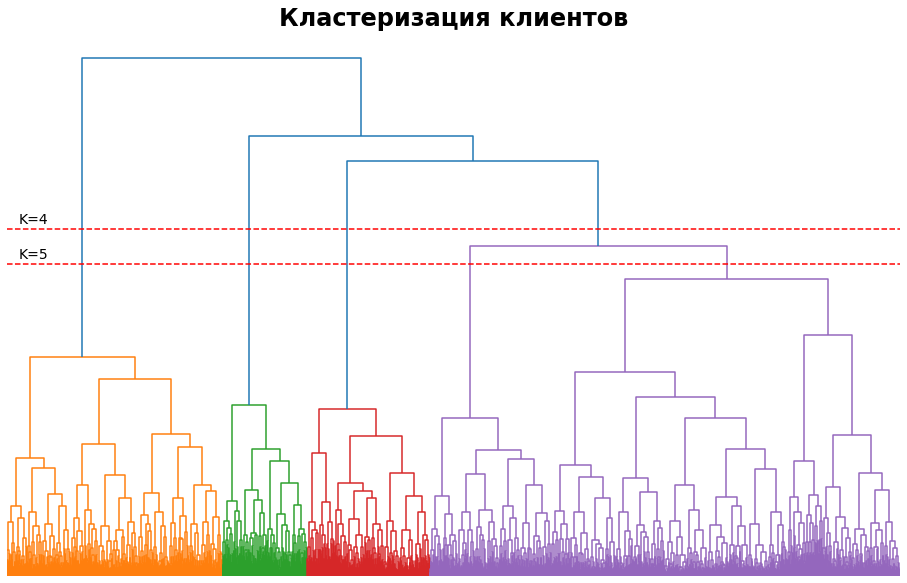

In [29]:
# создаем фигуру
fig, ax = plt.subplots(figsize=(16, 10))

# строим дендрограмму
dendrogram(
    linked,
    orientation='top',
    ax=ax
)

# добавляекм заголовок
ax.set_title('Кластеризация клиентов', fontsize=24)

# выделим линией уровень 4-х кластеров 
ax.axhline(70, color='red', linestyle='--')
ax.text(
    s='K=4',
    x=500,
    y=71,
    fontsize=14
)

# выделим линией уровень 5-и кластеров
ax.axhline(63, color='red', linestyle='--')
ax.text(
    s='K=5',
    x=500,
    y=64,
    fontsize=14
)

# уберем метки осей
plt.axis('off')

# выводим график
plt.show()

Алгоритм рекомендует выделить 4 кластера, но заказчик хочет видеть 5 кластеров. Слово заказчика – закон. Выделяем 5 класетров.

### Выделяем кластеры

Проведем кластеризацию на стандартизированных данных с помощью двух алгоритмов:
* KMeans
* Аггломеративной кластеризации

Затем оценим модели с помощью метрики silhouette score и выберем лучшую модель.

In [30]:
# создаем модель кластеризации с алгоритмом KMeans
km = KMeans(n_clusters=5, random_state=0)

# определяем кластеры 
labels_km = km.fit_predict(cluster_data_st)

In [31]:
# создаем модель кластеризации с алгоритмом AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=5)

# определяем кластеры
labels_ac = ac.fit_predict(cluster_data_st)

Модели готовы, посмотрим на их метрики и выберем лучшую:

In [32]:
print('KMeans:', silhouette_score(cluster_data_st, labels_km))
print('AgglomerativeClustering:', silhouette_score(cluster_data_st, labels_ac))

KMeans: 0.14140953623023356
AgglomerativeClustering: 0.12087728370538306


Судя по метрике silhouette score лучше себя показывает модель с алгоритмом KMeans. Добавим кластеры из этой модели в изначальный датасет:

In [33]:
# добавим столбец с кластерами в изначальный датасет
data['cluster'] = labels_km

Кластеры добавлены в наш исходный датасет. Теперь изучим кластеры.

### Изучим кластеры

Посмотрим на показатели кластеров по большинству признаков. Главный инструмент – графики. В конце сформулируем основные характеристики кластеров.

Для визуализации признаков которые принимают только значения 1 и 0, будем строить столбчатые диаграммы с долями показателя 1. Для визуализации остальных признаков будем строить ящики с усами.

Графиков будет много, поэтому для отрисовки каждого из них напишем отдельную функцию:

In [34]:
# функция для отрисовки ящика с усами
def box_plot(col): 
    # создаем фигуру
    fig = px.box(
        data_frame=data,
        x='cluster',
        y=col,
        color='cluster',
        color_discrete_sequence=colors,
        width=800,
    )

    # убираем легенду
    fig.update_layout(showlegend=False)

    # добавляем линию среднего значения
    fig.update_traces(
        boxmean=True,
    )

    # возвращаем фигуру
    return fig

In [35]:
# функция для отрисовки столбчатой диаграммы
def bar_plot(col, func='mean', text_template = '%{text:.0%}'):

    # строим график
    fig = px.bar(
        data_frame = data.groupby('cluster').agg({col: func}).reset_index(), # группируем данные по кластерам
        y=col,
        text=col,
        width=800,
        color_discrete_sequence=colors
    )

    # убираем легенду и настраиваем отступы между столбцами
    fig.update_layout(
        showlegend=False,
        bargap=0.4
    )

    # настраиваем отображение
    fig.update_traces(
        texttemplate=text_template, 
        textposition='outside',
        marker_color=colors
        )

    # возвращаем фигуру
    return fig

Посмотрим на размеры кластеров:

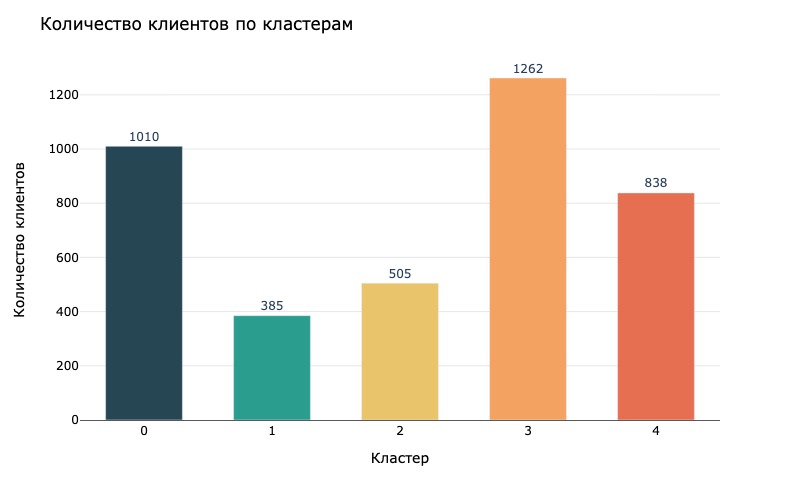

In [36]:
# строим фигуру
fig = bar_plot('gender', func='count', text_template='%{text:.10}')

# наводим красоту
style_plot(
    title='Количество клиентов по кластерам',
    xlabel='Кластер',
    ylabel='Количество клиентов'
)

# выводим график
fig.show()

Клиенты распределены по кластерам неравномерно. Самый большой кластер 3. Самый маленький кластер 1.

Посмотрим на распределение полов по кластерам:

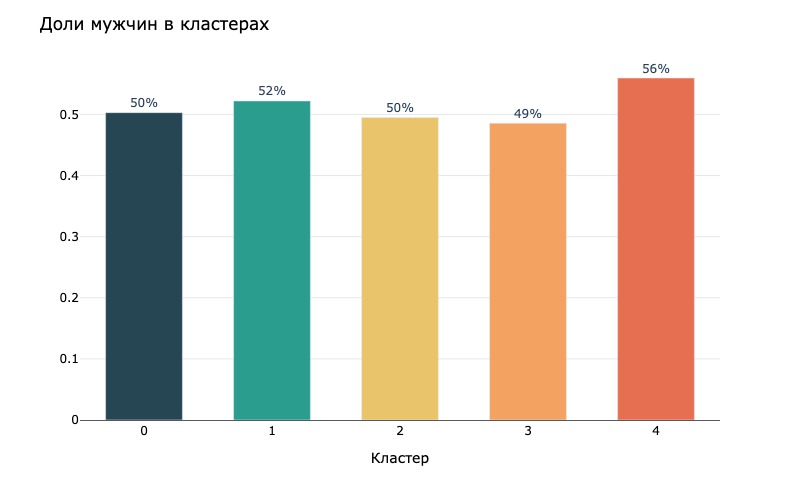

In [37]:
# строим фигуру
fig = bar_plot('gender')

# наводим красоту
style_plot(
    title='Доли мужчин в кластерах',
    xlabel='Кластер',
)

# выводим график
fig.show()

В целом соотношение мужчин и женщин во всех кластерах один к одному. Лишь в кластере 4 заметное преобладание мужчин (на 6%).

Посмотрим долю клиентов, у которых фитнес центры располагаются около работы или дома:

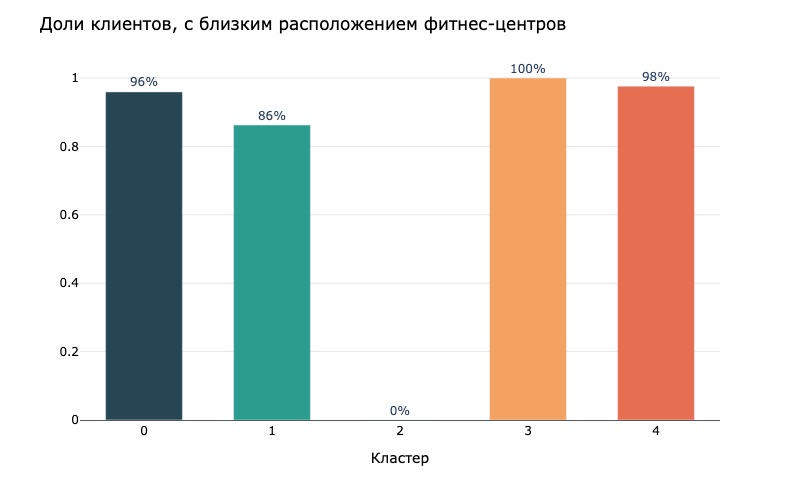

In [38]:
# строим фигуру
fig = bar_plot('near_location')

# наводим красоту
style_plot(
    title='Доли клиентов, с близким расположением фитнес-центров',
    xlabel='Кластер',
)

# выводим график
fig.show()

Здесь видно, что в кластере 2 находятся клиенты, которые живут или работают достаточно далеко от фитнес центра. В остальных же кластерах доля таких людей от 86% до 100%.

Теперь посмотрим на доли клиентов-партнеров по кластерам:

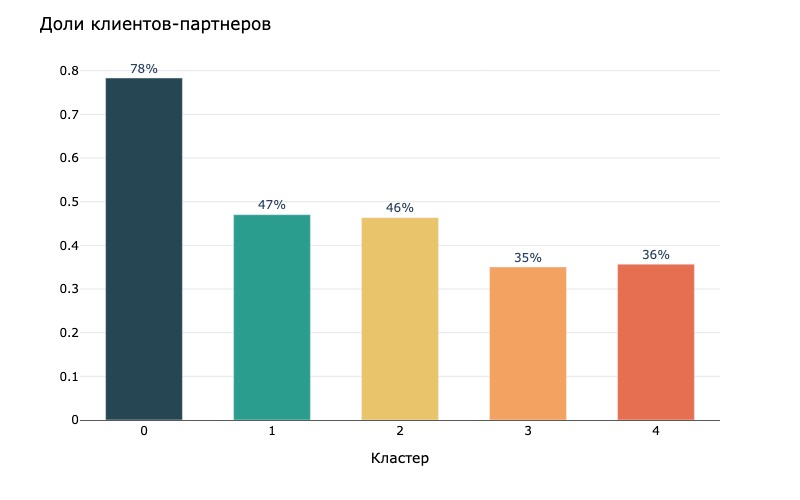

In [39]:
# строим фигуру
fig = bar_plot('partner')

# наводим красоту
style_plot(
    title='Доли клиентов-партнеров',
    xlabel='Кластер',
)

# выводим график
fig.show()

В кластере 0 большинство клиентов партнеры. В кластерах 1 и 2 таких клиентов примерно половина. А в кластерах 3 и 4 треть.

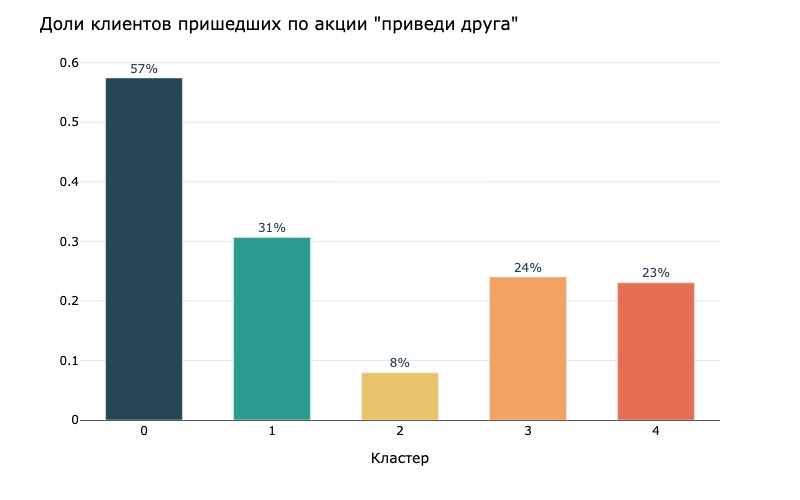

In [40]:
# строим фигуру
fig = bar_plot('promo_friends')

# наводим красоту
style_plot(
    title='Доли клиентов пришедших по акции "приведи друга"',
    xlabel='Кластер',
)

# выводим график
fig.show()

Больше половины клиентов кластера 0 пришли в зал по промо-акции "приведи друга". В кластере 1 таких пользователей треть. В кластерах 3 и 4 – 24% и 23% соответственно. А в кластере 2 таких клиентов лишь 8%.

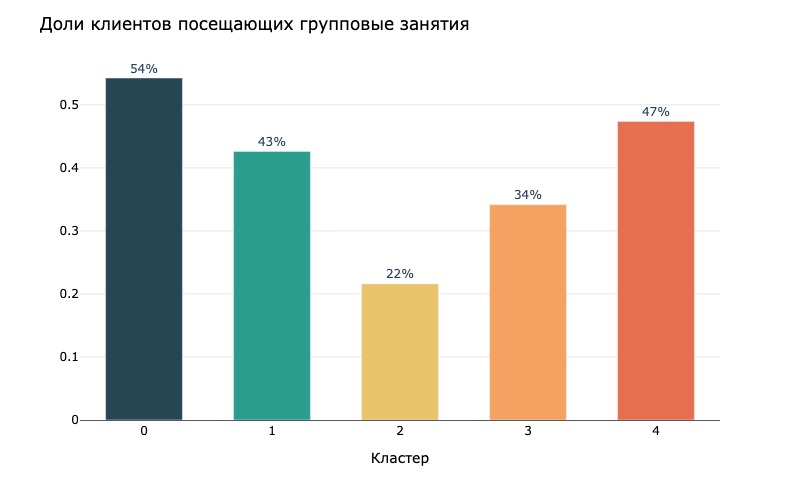

In [41]:
# строим фигуру
fig = bar_plot('group_visits')

# наводим красоту
style_plot(
    title='Доли клиентов посещающих групповые занятия',
    xlabel='Кластер',
)

# выводим график
fig.show()

Примерно половина клиентов кластеров 0 и 4 предпочитают групповые занятия. В кластере 2 любителей групповых занятий всего лишь 22%.

Посмотрим на распределение клиентов по возрастам:

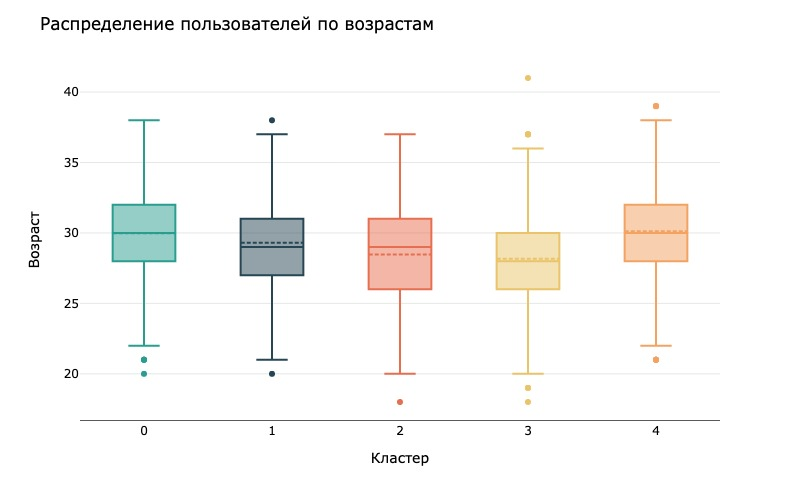

In [42]:
# строим фигуру
fig = box_plot('age')

# наводим красоту
style_plot(
    title='Распределение пользователей по возрастам',
    xlabel='Кластер',
    ylabel='Возраст'
)

# выводим график
fig.show()

Средний возраст клиентов в кластерах варьируется не сильно – от 28 (в кластере 3) до 30 (в кластере 4). Также в кластере 3 самый большой дипазон значений – от 18 до 41.

Посмотрим сколько дополнительных трат совершают клиенты разных кластеров:

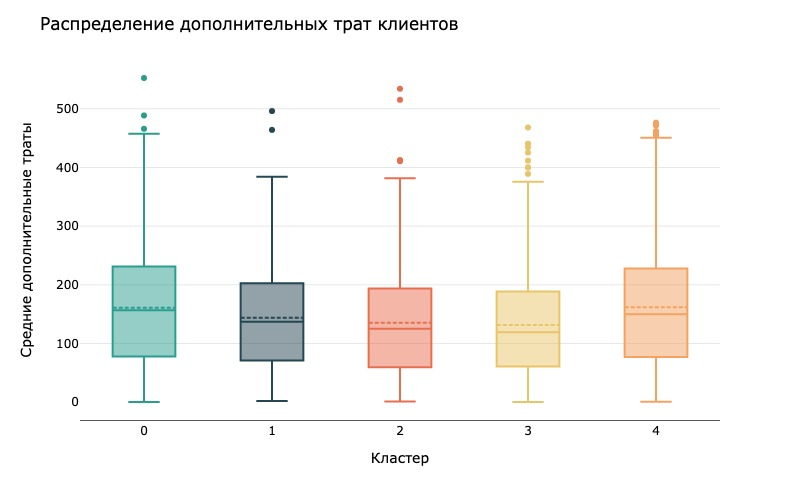

In [43]:
# строим фигуру
fig = box_plot('avg_additional_charges_total')

# наводим красоту
style_plot(
    title='Распределение дополнительных трат клиентов',
    xlabel='Кластер',
    ylabel='Средние дополнительные траты'
)

# выводим график
fig.show()

Медианные траты по кластерам не слишком сильно отличаются. Они находятся в диапазоне от 119 (в кластере 3) до 156 (в кластере 0). Во всех кластерах присутствуют по нескольку выбросов. Самый большой выброс в кластере 0, его значение 552.

Построим распределение кластеров по длительности текущего контракта:

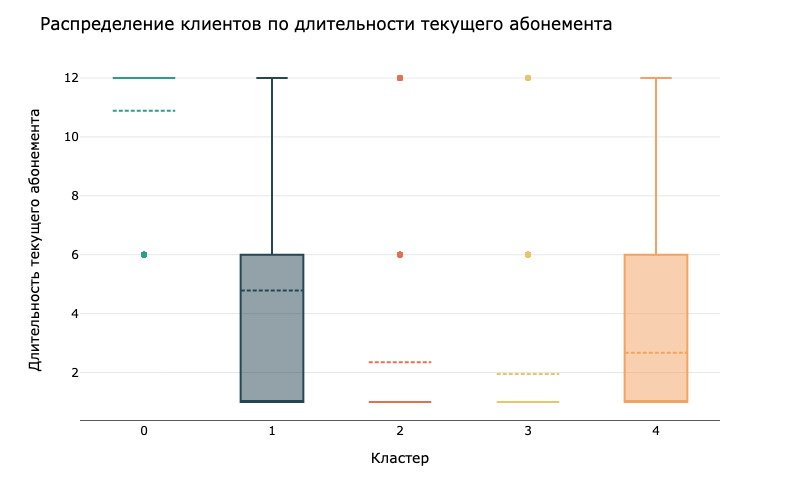

In [44]:
# строим фигуру
fig = box_plot('contract_period')

# наводим красоту
style_plot(
    title='Распределение клиентов по длительности текущего абонемента',
    xlabel='Кластер',
    ylabel='Длительность текущего абонемента'
)

# выводим график
fig.show()

Распределение получилось интересным:
* В кластер 0 попали клиенты у которых абонементы на 12 месяцев. Но есть несколько значений 6 месяцев, поэтому среднее немного ниже медианы,
* В кластерах 2 и 3 основная масса клиентов имеют абонементы на 1 месяц. В этих кластерах также есть несколько выбивающихся значений, поэтому среднее выше медианы.
* В кластерах 1 и 4 также медианное значение длительности текущего абонемента – 1 месяц. Но в этих кластерах присутствует достаточно значений, чтобы утянуть 75-й перцентиль на показатель 6 месяцев.

Теперь посмотрим сколько месяцев по абонементу осталдось у клиентов разных кластеров:

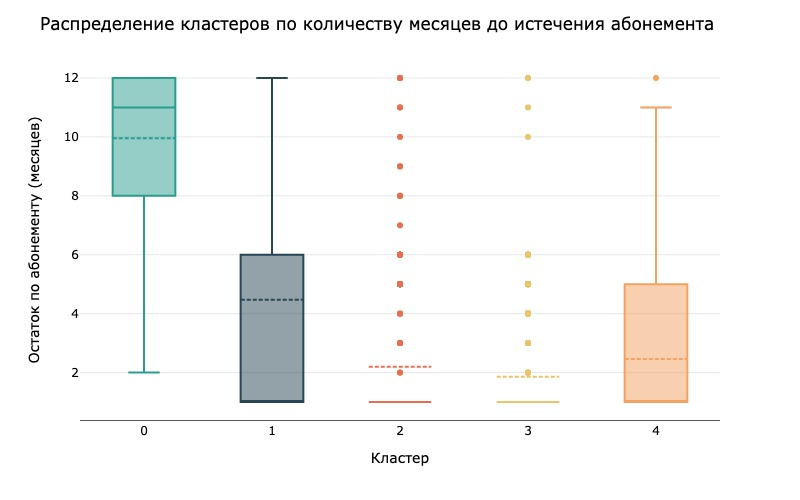

In [45]:
# строим фигуру
fig = box_plot('month_to_end_contract')

# наводим красоту
style_plot(
    title='Распределение кластеров по количеству месяцев до истечения абонемента',
    xlabel='Кластер',
    ylabel='Остаток по абонементу (месяцев)'
)

# выводим график
fig.show()

В кластерах 2 и 3 медианное значение месяцев до истечения абонемента – 1, но также присутствуют выбросы от 2 до 12 месяцев, поэтому среднее смещено выше относительно медианы. В кластере 0 клиенты наоборот имеют в основном абонементы с длительным сроком. В кластерах 1 и 4 медианы также равны 1, но присутствует также множестно других значений.

Посмотрим на показатели лайфтайма по кластерам:

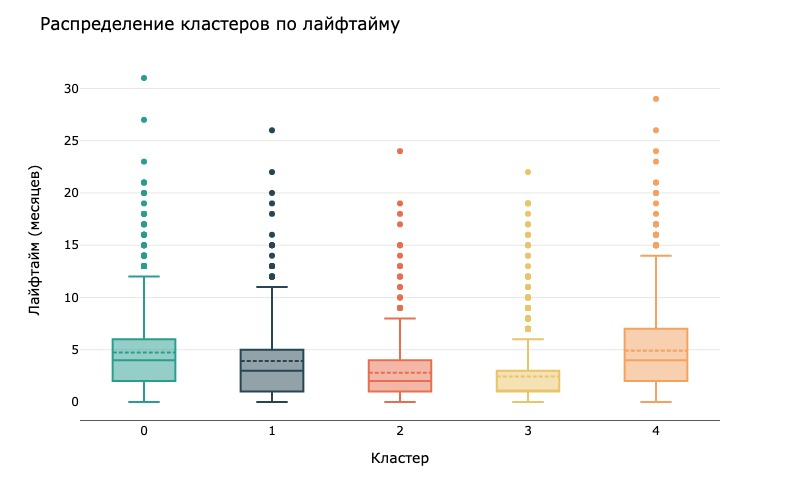

In [46]:
# строим фигуру
fig = box_plot('lifetime')

# наводим красоту
style_plot(
    title='Распределение кластеров по лайфтайму',
    xlabel='Кластер',
    ylabel='Лайфтайм (месяцев)'
)

# выводим график
fig.show()

Во всех кластерах встречаются выбивающиеся значения. Самые лояльные клиенты находятся в кластере 4. В кластере 3 медианное значение лайфтайма равно 1 месяцу.

Теперь построим график с средним количеством посещений фитнес-центра в неделю:

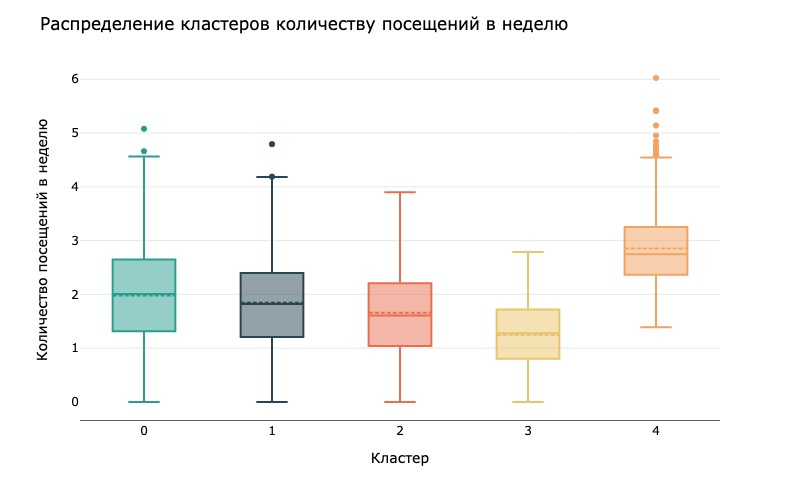

In [47]:
# строим фигуру
fig = box_plot('avg_class_frequency_total')

# наводим красоту
style_plot(
    title='Распределение кластеров количеству посещений в неделю',
    xlabel='Кластер',
    ylabel='Количество посещений в неделю'
)

# выводим график
fig.show()

Самые активные спортсмены находятся в 4 кластере. Клиентов кластера 3 видят в зале реже всего. В остальных кластерах этот признак отличается не сильно.

Изучим тот же показатель, только за последний месяц:

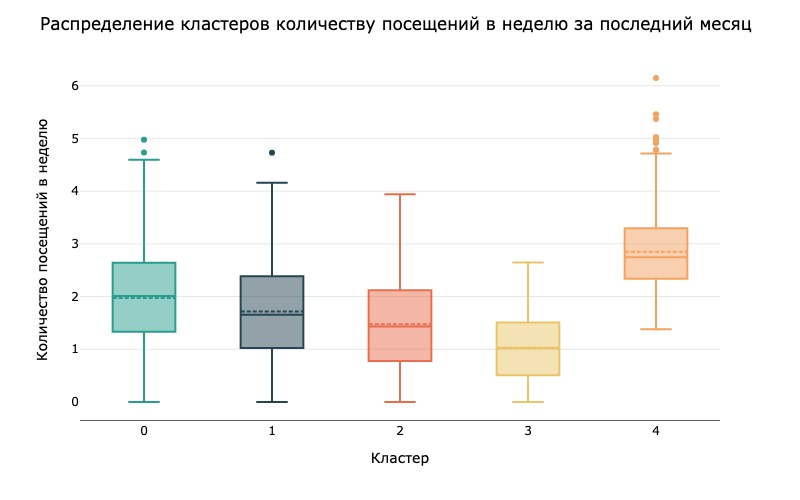

In [48]:
# строим фигуру
fig = box_plot('avg_class_frequency_current_month')

# наводим красоту
style_plot(
    title='Распределение кластеров количеству посещений в неделю за последний месяц',
    xlabel='Кластер',
    ylabel='Количество посещений в неделю'
)

# выводим график
fig.show()

Разница этого признака и предыдущего невелика. Все значения похожи.

И финальное, выведем показатель оттока по кластерам:

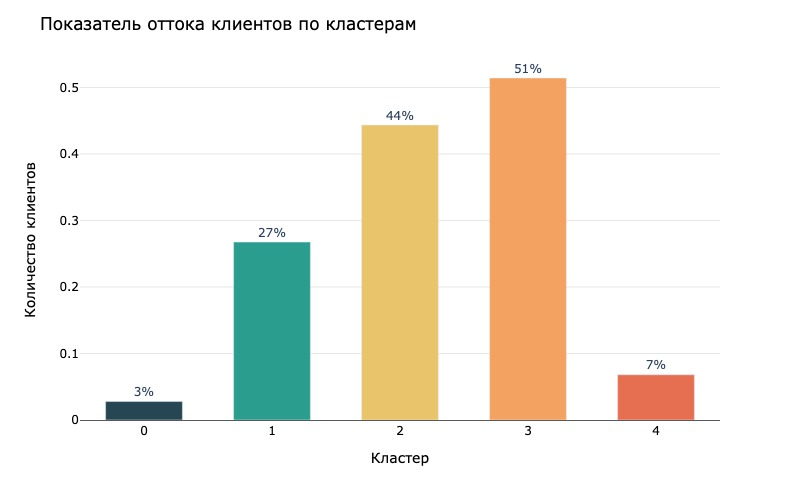

In [49]:
# строим фигуру
fig = bar_plot('churn')

# наводим красоту
style_plot(
    title='Показатель оттока клиентов по кластерам',
    xlabel='Кластер',
    ylabel='Количество клиентов'
)

# выводим график
fig.show()

Более половины клиентов из кластера 3 ушло! В кластере 2 ситуация также плачевная: показатель оттока 44%. Немного лучше ситуация с кластером 1, там ушла четверть клиентов. 

Самые позитивные показатели у кластеров 0 и 4, там процент оттока равен 3% и 7% соответственно.

### Выводы

Мы увидели очень много графиков. Теперь настало время дать характеристики кластеров. Для того, чтобы освежить данные выведем таблицу со средними значениями по кластерам:

In [50]:
# создадим датафрейм и добавим в него средние значения по каждому кластеру
cluster_mean = pd.DataFrame(
    {('cluster_' + str(cluster)): data.query('cluster == @cluster').mean() for cluster in range(5)}
).round(2).reset_index()

# заменим строку с индексом cluster на размер кластера
cluster_mean.iloc[-1] = ['cluster_size'] +[data.query('cluster == @cluster')['gender'].count() for cluster in range(5)]

# вернем в индексы признаки
cluster_mean = cluster_mean.set_index('index', )

In [51]:
# выведем получившуюся таблицу на экран
cluster_mean

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
index,,,,,
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66


**Клиентов из кластера 0 характеризует:**
* длительный абонемент (в среднем почти 11 месяцев),
* близость дома или работы к фитнес-центру (у 96% клиентов),
* большинство клиентов этого кластера партнеры фитнес-центра (78%),
* более половины посещают групповые занятия (57%),
* высокий лайфтайм (почти 5 месяцев),
* стабильная посещаемость (по разнице показателя посещений в среднем и в последний месяц)
* низкий показатель оттока (3%)

**Клиентов из кластера 1 характеризует:**
* средняя длительность абонемента (около 5 месяцев),
* снижение показателя посещений зала в последний месяц (отностительно показателя за все время),
* средний показатель оттока (27%),

**Клиентов из кластера 2 характеризует:**
* удаленность фитнес-ценра от дома или работы,
* низкая доля посещений групповых занятий (22%),
* снижение показателя посещений зала в последний месяц (отностительно показателя за все время),
* высокий показатель оттока (44%)

**Клиентов из кластера 3 характеризует:**
* все они работают или живут рядом с фитнес-центром,
* самая низкая средняя длительность абонемента (в среднем менее 2-х месяцев)
* низкое число посещений фитнес-центра в неделю (за все время в среднем 1,25 раза, а за последний месяц 1,01 раза),
* самые низкие дополнительные траты (в среднем на 131$),
* самая высокая доля оттока (51%)

**Клиентов из кластера 4 характеризует:**
* близость дома или работы к фитнес-центру (у 98% клиентов),
* самые возрастные клиенты (средний возраст более 30 лет),
* самый высокий лайфтайм (в среднем чуть меньше 5-и месяцев),
* самые высокие дополнительные траты (161$),
* самое высокое среднее количество посещений фитнес-центра в неделю (в среднем почти 3 раза),
* низкий показатель оттока (7%)




## Общие выводы

В начале исследования мы сформулировали задачи заказчика. Напомним их:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    * выделить целевые группы клиентов;
    * предложить меры по снижению оттока;
    * определить другие особенности взаимодействия с клиентами.

Пойдем прямо по пунктам.

### Прогнозирование вероятности оттока

Для прогнозирования оттока мы применили несколько алгоритмов классификации: логистическую регрессию с L1 регуляризацией, логистическую регрессию с L2 регуляризацией, случайный лес, градиентный бустинг.

Качество модели с разными алгоритмами мы измеряли по метрикам accuracy, precision, recall и f1. По комбинации этих метрик мы выбрали модель с алгоритмом градиентного бустинга. Эту модель мы и рекомендуем для дальнейшего прогнозирования.

### Формирование типичных портретов клиентов

Для выполнения этой задачи мы провели кластеризацию клиентов. Как и было указано у заказчика мы выделили 5 кластеров. Вот какие характеристики оказались у клиентов из разных кластеров:

**Клиентов из кластера 0 характеризует:**
* длительный абонемент (в среднем почти 11 месяцев),
* близость дома или работы к фитнес-центру (у 96% клиентов),
* большинство клиентов этого кластера партнеры фитнес-центра (78%),
* более половины посещают групповые занятия (57%),
* высокий лайфтайм (почти 5 месяцев),
* стабильная посещаемость (по разнице показателя посещений в среднем и в последний месяц)
* низкий показатель оттока (3%)

**Клиентов из кластера 1 характеризует:**
* средняя длительность абонемента (около 5 месяцев),
* снижение показателя посещений зала в последний месяц (отностительно показателя за все время),
* средний показатель оттока (27%),

**Клиентов из кластера 2 характеризует:**
* удаленность фитнес-ценра от дома или работы,
* низкая доля посещений групповых занятий (22%),
* снижение показателя посещений зала в последний месяц (отностительно показателя за все время),
* высокий показатель оттока (44%)

**Клиентов из кластера 3 характеризует:**
* все они работают или живут рядом с фитнес-центром,
* самая низкая средняя длительность абонемента (в среднем менее 2-х месяцев)
* низкое число посещений фитнес-центра в неделю (за все время в среднем 1,25 раза, а за последний месяц 1,01 раза),
* самые низкие дополнительные траты (в среднем на 131$),
* самая высокая доля оттока (51%)

**Клиентов из кластера 4 характеризует:**
* близость дома или работы к фитнес-центру (у 98% клиентов),
* самые возрастные клиенты (средний возраст более 30 лет),
* самый высокий лайфтайм (в среднем чуть меньше 5-и месяцев),
* самые высокие дополнительные траты (161$),
* самое высокое среднее количество посещений фитнес-центра в неделю (в среднем почти 3 раза),
* низкий показатель оттока (7%)

### Анализ признаков влияющих на отток

Если соединить знания о кластерах и из исследовательского анализа, то можно выделить несколько маркеров, влияющих на вероятность оттока:
* низкая длительность абонемента,
* отсутствие посещений групповых занятий,
* молодой возраст,
* маленький лайфтайм,
* низкая посещаемость в неделю,

### Рекомендации по работе с клиентами

Судя по всему, в основном уходят новички. То есть люди, которые впервые записываются на занятия. Это мы можем понять по низкому лайфтайму и относительно молодому возрасту. 

Чтобы снизить отток таких клиентов можно направить маркетинговую активность на продвижение групповых занятий. Судя по данным, дольше остаются клиенты, которые посещают такие занятия. Возможно, групповые занятия это не только про спорт, но и про комьюнити. Новичками будет проще адаптироваться в фитнес-центре, если они будут посещать групповые занятия.

Также на показатель оттока влияет длительность абонемента. Клиентам следуют активно продавать абонементы длительностью полгода или год. Если такого еще нет, то стоит ввести специальные предложения на долгосрочные абонементы.